In [1]:
import tuner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tuner.check_gpu()

Num GPUs Available:  1
TensorFlow will run on GPU.


# Load Dataset

In [3]:
features = [["Temp", "RelHum", "PresBarometr", "RadSolar", "RapViento"],
            ["Temperature", "Relative Humidity", "Barometric Pressure", "Solar Radiation", "Wind Speed"],
            ["°C", "%", "hPa", "W/m^2", "m/s"]]

In [4]:
data = pd.read_csv("Monterrey.csv") # Load the CSV data into a DataFrame
data['Fecha'] =  pd.to_datetime(data['Fecha'], format='%m/%d/%y %H:%M') # Format the date information
data.set_index('Fecha', inplace=True) # Set the timestamp column as the index
data = data[features[0]] # Removing non-features
data = data.dropna() # Drop NaNs
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 409000 entries, 2005-05-09 10:00:00 to 2023-03-03 15:20:00
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Temp          409000 non-null  float64
 1   RelHum        409000 non-null  float64
 2   PresBarometr  409000 non-null  float64
 3   RadSolar      409000 non-null  float64
 4   RapViento     409000 non-null  float64
dtypes: float64(5)
memory usage: 18.7 MB


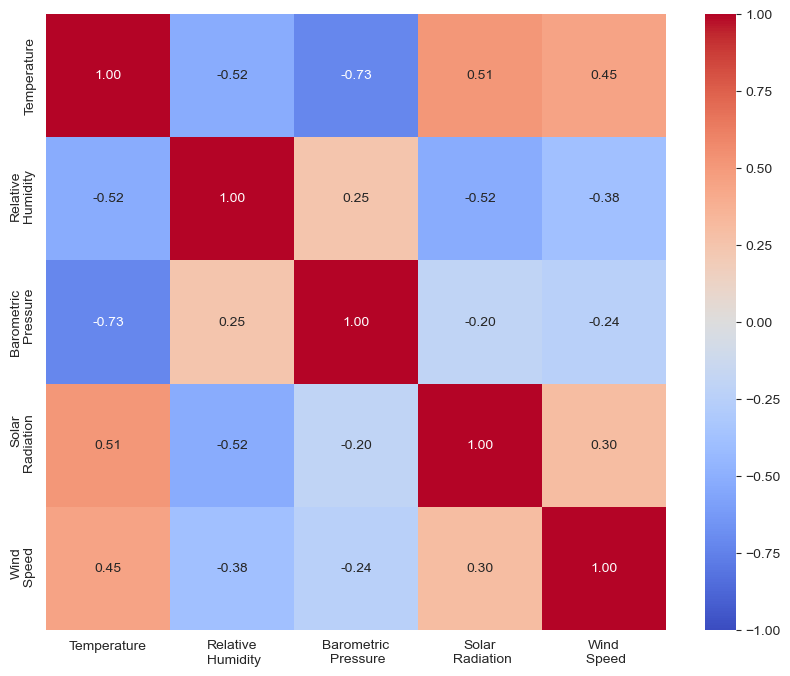

In [5]:
correlation_matrix = data.corr()
new_names = {
    "Temp": "Temperature",
    "RelHum": "Relative\n Humidity",
    "PresBarometr": "Barometric\n Pressure",
    "RadSolar": "Solar\n Radiation",
    "RapViento": "Wind\n Speed",

}
correlation_matrix.rename(columns=new_names, index=new_names, inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

# Tuner

In [6]:
# Basic settings
n_lag     = 24*7 # Number of lags (time steps back) to use for prediction
n_ahead   = 24*7 # Number of time steps ahead to forecast
n_ft      = data.shape[1] # Number of features (weather variables)
epochs    = 20 # Number of epochs for training
test_size = 0.2 # Define portion to use for the test set

# Hypermodel settings
max_trials           = 100 # Number of trials the Hypermodel will run
executions_per_trial = 2 # Number of executions of the model per trial
directory            = '1hr_tuner' # Directory name where results will be saved

# Hyperparameter ranges
layer_range         = (1, 3) # Range of LSTM layers
unit_range          = (10, 100) # Range of units in each LSTM layer
activation_choices  = ['relu', 'tanh', 'sigmoid', 'softmax'] # Range of activation functions
learning_rate_range = (1e-4, 1e-1)  # Range for the learning rate
loss_functions      = ['MAE'] # List of activation functions to choose from
batch_size_range    = (32, 128) # Range for batch size selection

In [7]:
hypermodel = tuner.LSTMTuner(
    input_shape         = [n_lag, n_ft],
    n_outputs           = n_ahead,
    layer_range         = layer_range,
    unit_range          = unit_range,
    activation_choices  = activation_choices,
    learning_rate_range = learning_rate_range,
    loss_functions      = loss_functions,
    batch_size_range    = batch_size_range
)

In [8]:
data_scaled, train_mean, train_std = tuner.scale_data(data, test_size)

# Predictive models

## Temperature

In [9]:
target_index = 0 # Select proper target index as the weather variable to predict in the features array

In [10]:
# Prepare the dataset for the model
X_train, Y_train, X_val, Y_val = tuner.prepare_data(
    data_scaled.values,
    n_lag        = n_lag,
    n_ahead      = n_ahead,
    target_index = target_index,
    test_size    = test_size
)

In [11]:
# Initialize the tuner
Temp_tuner = tuner.RandomSearch(
    hypermodel,
    objective               = 'val_loss',
    max_trials              = max_trials,
    executions_per_trial    = executions_per_trial,
    directory               = directory,
    project_name            = features[1][target_index]
)

In [12]:
# Search best parameters
Temp_tuner.search(
    x               = X_train,
    y               = Y_train,
    epochs          = epochs,
    validation_data = (X_val, Y_val)
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
40                |40                |units_0
relu              |relu              |activation_0
MAE               |MAE               |loss_function
32                |32                |batch_size
0.037178          |0.037178          |learning_rate

Epoch 1/20
 3362/10217 [========>.....................] - ETA: 48:42 - loss: nan

KeyboardInterrupt: 

In [ ]:
best_hyperparameters = Temp_tuner.get_best_hyperparameters(num_trials=1)[0]
best_loss_function = best_hyperparameters.get('loss_function')
for param in best_hyperparameters.values:
    print(f"{param}: {best_hyperparameters.get(param)}")